# Autoformer for causal data

In [1]:
import pandas as pd
import os

root_path = "../../Datasets/"
data_path = "data_causal_1.csv"

df_raw = pd.read_csv(os.path.join(root_path, data_path))

In [2]:
df_raw

,date,0,1,OT
0,2016-07-01 02:00:00,-0.407538,-0.336129,0.920508
1,2016-07-01 03:00:00,0.656062,0.201795,0.908391
2,2016-07-01 04:00:00,-0.600335,-0.614088,1.590749
3,2016-07-01 05:00:00,-1.318435,-1.031525,1.261361
4,2016-07-01 06:00:00,-0.537878,-0.611075,1.142448
...,...,...,...,...
9995,2017-08-21 13:00:00,2.080072,1.129325,0.597037
9996,2017-08-21 14:00:00,-0.420223,-0.722067,1.653656
9997,2017-08-21 15:00:00,0.233041,0.309030,1.207648
9998,2017-08-21 16:00:00,1.145924,0.863393,0.810743


In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
import sys

sys.path.append("..")
sys.path.append("../..")
sys.path.append("../../../")

In [5]:
import torch
from models import Autoformer


def obtain_autoformer(pred_len, dataset, el=2, nh=8):
    # dataset = [sinusoidal]
    assert pred_len in [96, 192, 336, 720]

    args = dotdict()
    args.pred_len = pred_len

    args.label_len = 48

    args.target = "OT"
    args.des = "train"
    args.dropout = 0.05
    args.num_workers = 10
    args.gpu = 0
    args.lradj = "type1"
    args.devices = "0"
    args.use_gpu = False
    args.use_multi_gpu = False
    args.freq = "h"
    args.checkpoints = "./checkpoints/"
    args.bucket_size = 4
    args.n_hashes = 4
    args.is_training = False
    args.data = "custom"
    args.seq_len = 96
    # args.label_len = 48
    args.e_layers = el
    args.d_layers = 1
    args.n_heads = nh
    args.d_model = 512
    args.des = "Exp"
    args.itr = 1
    args.d_ff = 2048
    args.moving_avg = 25
    args.factor = 1
    args.distil = True
    args.output_attention = True  # in order to save hooks
    args.embed = "timeF"

    if "ECL" in dataset:
        args.factor = 3
        args.enc_in = 321
        args.dec_in = 321
        args.c_out = 321
        args.features = "M"
    elif "causal" or "CAUSAL" in dataset:
        args.enc_in = 3
        args.dec_in = 3
        args.c_out = 3
        args.features = "M"
    else:
        args.factor = 1
        args.enc_in = 1
        args.dec_in = 1
        args.c_out = 1
        args.features = "S"

    # autoformer_path = f"../../{dataset}_96_{pred_len}_Autoformer_{'ETTm2' if dataset == 'ETTm2' else 'custom'}_ft{args.features}_sl96_ll{'96' if dataset == 'ETTm2' else '48'}_pl{pred_len}_dm512_nh{nh}_el{el}_dl1_df2048_fc{args.factor}_ebtimeF_dtTrue_Exp_0/checkpoint.pth"
    autoformer_path = "../checkpoints/seed42_CAUSAL_96_96_2_Autoformer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el4_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/checkpoint.pth"

    autoformer = Autoformer.Model(args).float()
    autoformer.load_state_dict(
        torch.load(autoformer_path, map_location=torch.device("cpu"))
    )

    autoformer.eval()

    return autoformer

In [6]:
from data_provider.data_loader import Dataset_Custom
from torch.utils.data import DataLoader


def obtain_data_loader(pred_len, label_len=48, seq_len=96, split="train"):

    rootpath = "../../Datasets/"
    datapath = "data_causal_1.csv"

    dataset = Dataset_Custom(
        root_path=rootpath,
        data_path=datapath,
        flag=split,  # flag must be train in order for the linear dataloader to contain the same data
        size=[seq_len, label_len, pred_len],  # seq_len, label_len, pred_len
        features="M",
        target="OT",  # default
        timeenc=1,
        freq="h",
    )

    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0,
        drop_last=False,
    )
    return dataloader

In [7]:
autoformer = obtain_autoformer(pred_len=96, dataset="seed42_CAUSAL", el=4, nh=8)
data_loader = obtain_data_loader(pred_len=96, label_len=48, seq_len=96, split="train")

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def obtain_plot_predictions(
    pred_len,
    data_set,
    data_loader,
    model,
    stimulus=None,
    name_plot="",
    to_save=False,
    name_fig="",
    label_len=48,
    item=0,
    alpha_gt=1,
    alpha_pred=0.5,
    vlines=[],
    timestamps=False,
):
    with torch.no_grad():
        for i, (seq_x, seq_y, seq_x_mark, seq_y_mark) in enumerate(data_loader):
            if i == item:
                # seq_x is batch_size x seq_len x N_timeseries
                # seq_y is batch_size x (label_len + pred_len) x N_timeseries
                # seq_x_mark is batch_size x seq_len X N_timefeatures
                # seq_y_mark is batch_size x (label_len+pred_len) X N_timefeatures
                if stimulus is not None:
                    seq_x, seq_y, seq_x_mark, seq_y_mark = stimulus

                # decoder input
                dec_inp = torch.zeros_like(seq_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([seq_y[:, :label_len, :], dec_inp], dim=1).float()

                # gt = np.concatenate((seq_x[0, :, 0], seq_y[0, -pred_len:, 0]), axis=0)
                gt = np.concatenate((seq_x[0, :, -1], seq_y[0, -pred_len:, -1]), axis=0)

                outputs_autoformer, _ = model(
                    seq_x.float(), seq_x_mark.float(), dec_inp, seq_y_mark.float()
                )
                pd_autoformer = np.concatenate(
                    (
                        [np.nan for i in range(seq_x.shape[1])],
                        outputs_autoformer[0, -pred_len:, -1],
                    ),
                    axis=0,
                )

                plt.plot(gt, label="ground truth", color="black", alpha=alpha_gt)
                plt.plot(pd_autoformer, label="autoformer", alpha=alpha_pred)

                for vline in vlines:
                    plt.axvline(x=vline, color="b", linestyle="--")

                plt.legend()
                plt.xlabel("Time")
                plt.ylabel("Scaled time series")
                plt.suptitle(data_set)

                # if timestamps:
                #     time_feat = time_features_from_frequency_str_uncalled("h")
                #     x_timestamps = obtain_timestamps(seq_x_mark, time_feat)
                #     y_timestamps = obtain_timestamps(seq_y_mark, time_feat)[-pred_len:]
                #     timestamps = x_timestamps + y_timestamps

                #     tick_positions = [
                #         i
                #         for i, tick_label in enumerate(timestamps)
                #         if tick_label.startswith("0H")
                #     ]
                #     tick_labels = [timestamps[i][3:] for i in tick_positions]
                #     plt.xticks(tick_positions, tick_labels, rotation=45)
                #     plt.grid(True)

                if to_save:
                    # plt.savefig(f"plots/{name_plot}.png")
                    plt.savefig(name_fig, bbox_inches="tight")
                plt.show()

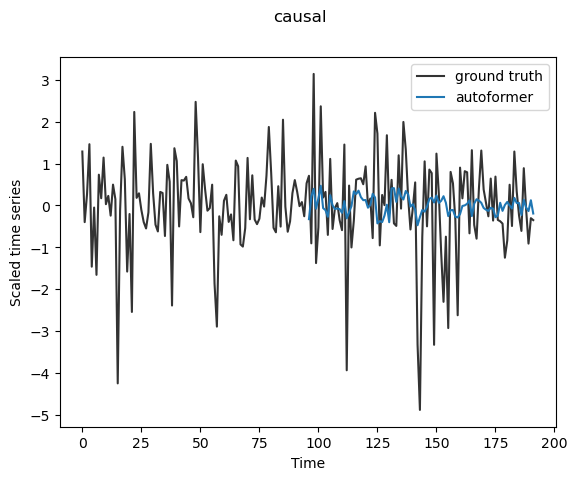

In [9]:
obtain_plot_predictions(
    pred_len=96,
    data_set="causal",
    data_loader=data_loader,
    model=autoformer,
    alpha_gt=0.8,
    alpha_pred=1,
)

In [10]:
data_loader_train = obtain_data_loader(
    pred_len=96, label_len=48, seq_len=96, split="train"
)
data_loader_val = obtain_data_loader(pred_len=96, label_len=48, seq_len=96, split="val")
data_loader_test = obtain_data_loader(
    pred_len=96, label_len=48, seq_len=96, split="test"
)

In [13]:
print(len(data_loader_train))
print(len(data_loader_val))
print(len(data_loader_test))

6809
905
1905


In [14]:
96 + 48 + 96

240